In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

Functions:


In [40]:
def normal_size(fpath, size=(50,50)):
    """
    Resize an image to the given size and normalize pixel intensity to [0, 1]. Use for smaller datasets/testing.
    """
    img = cv2.imread(fpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    img = img / 255.0
    return img


def split(labels):
    """
    Split the dataset into training and validation sets.
    """
    train_img, val_img = train_test_split(labels, test_size=0.2, random_state=42, stratify=labels['label'])
    return train_img, val_img


def cvt_to_dataset(df, batch_size=32, img_size=(50, 50), labelled=True, cache_path=None):
    """
    Convert a DataFrame to a TensorFlow dataset. Implement caching at a later stage for performance improvement.
    """
    file_path = df['file_path'].values
    label = df['label'].values if labelled else None

    def handle_img(file_path): 
        """
        Read and preprocess a TIFF image file.
        """
        if isinstance(file_path, tf.Tensor):
            file_path = file_path.numpy() 
        if isinstance(file_path, (bytes, np.bytes_)):
            file_path = file_path.decode('utf-8')
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0

        return img.astype(np.float32)
    
    def load_and_reshape(file_path, label=None):
        """
        Returns image and label (if available) in the correct shpae ready to be converted to dataset.
        """
        img = tf.numpy_function(handle_img, [file_path], tf.float32)
        img.set_shape([50, 50, 3])

        if labelled:
            label = tf.cast(label, tf.float32)
            return img, label
        else:
            return img

    if labelled:
        dataset = tf.data.Dataset.from_tensor_slices((file_path, label))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(file_path)
    
    dataset = dataset.map(load_and_reshape, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache(cache_path) if cache_path else dataset
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

def create_model(input_shape=(50, 50, 3), conv_filters=[32, 64], dense_units=64):
    """
    CNN model to classify images.
    """
    data_augmentation = tf.keras.Sequential([
        layers.RandomZoom(0.1),
        layers.RandomRotation(0.1),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomContrast(0.1),
    ])

    model = models.Sequential([
    layers.Input(input_shape),
    data_augmentation,
    layers.Conv2D(conv_filters[0], (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(conv_filters[1], (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(dense_units, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
    ])

    return model

def compile_model(model):
    """
    Compile the CNN model.
    """
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.Accuracy()]
    )

    return model

def train_model(model, train_ds, val_ds, epochs=10):
    """
    Train CNN model with training and validation datasets.
    """
    checkpoint = ModelCheckpoint(
        'E:/Coding_stuffs/Python/notebooks/Medical_image_classification/models',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1,
        save_freq='epoch'
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    training = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint, early_stop])
    
    return training


Linking images to labels

In [41]:
labels = pd.read_csv("../data/raw/histopathologic-cancer-detection/train_labels.csv")
labels['file_path'] = "../data/raw/histopathologic-cancer-detection/train/" + labels['id'] + ".tif"
pd.set_option('display.max_colwidth', None)
labels.head()


,id,label,file_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../data/raw/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../data/raw/histopathologic-cancer-detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,../data/raw/histopathologic-cancer-detection/train/755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../data/raw/histopathologic-cancer-detection/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../data/raw/histopathologic-cancer-detection/train/068aba587a4950175d04c680d38943fd488d6a9d.tif


Checking images load correctly

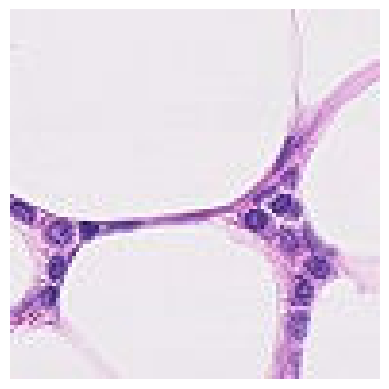

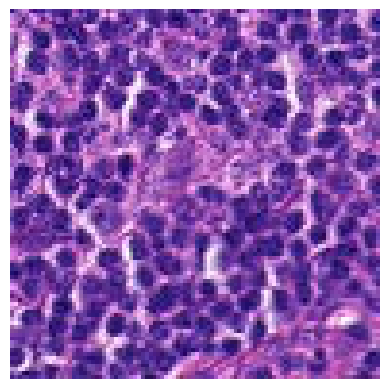

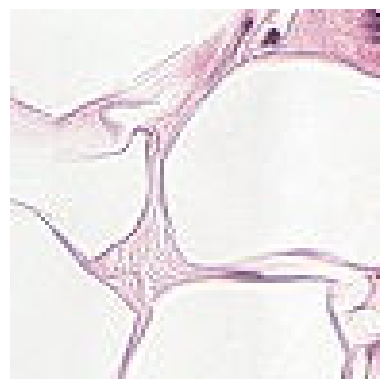

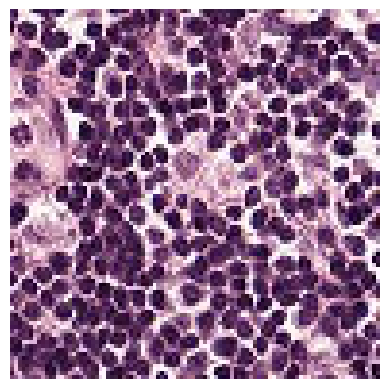

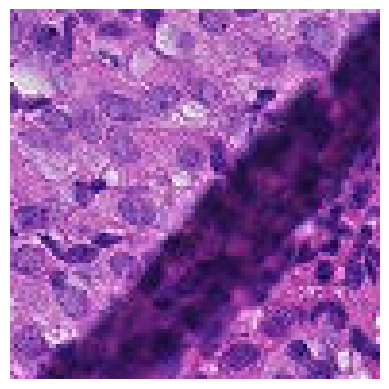

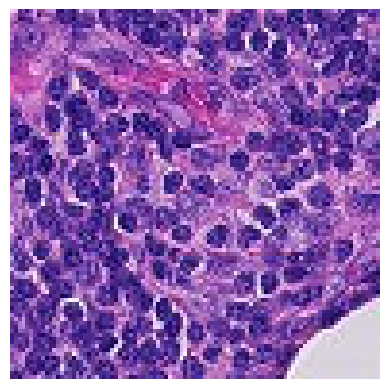

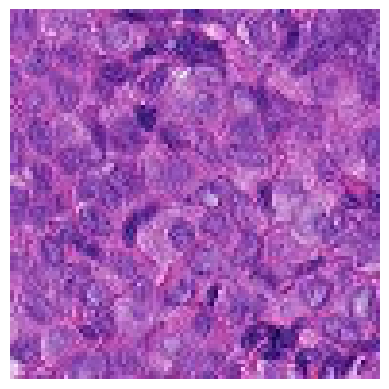

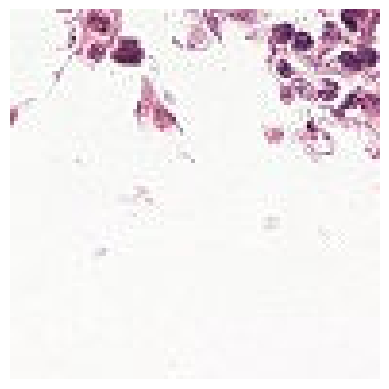

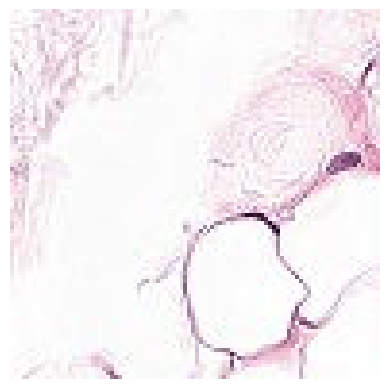

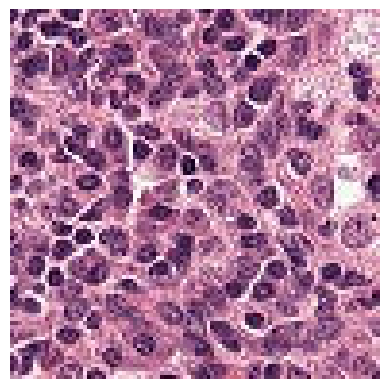

In [42]:
check = labels.sample(10, random_state=17)
for i, row in check.iterrows():
    img = cv2.imread(row["file_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Train test splitting

In [43]:
train_img, val_img = split(labels)

Creating test dataframe, converting all dataframes to tf datasets, loading and preprocessing all images

In [44]:
test_files = [os.path.join("../data/raw/histopathologic-cancer-detection/test/", f) for f in os.listdir("../data/raw/histopathologic-cancer-detection/test")]
test_df = pd.DataFrame(test_files, columns=['file_path'])

ds_train = cvt_to_dataset(train_img, labelled=True, cache_path="E:/tensorflow_caches/train_cache")
ds_val = cvt_to_dataset(val_img, labelled=True, cache_path="E:/tensorflow_caches/validation_cache")
ds_test = cvt_to_dataset(test_df, labelled=False)

In [45]:
model = create_model()
model = compile_model(model)
training = train_model(model, ds_train, ds_val, epochs=20)

Epoch 1/20
 953/5501 [====>.........................] - ETA: 5:11 - loss: 0.5994 - precision_12: 0.6639 - recall_12: 0.3751 - auc_12: 0.7260 - accuracy: 0.0000e+00

KeyboardInterrupt: 